# Kernel Approximation Experiment

In [8]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [ ]:
from jax import config
config.update("jax_enable_x64", True)

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
from jax.lib import xla_bridge
import equinox as eqx
from tinygp.kernels import ExpSquared

In [24]:
from steinRF.gp.kernels import RFF
from steinRF.stein.targets import TFTarget, GMMTarget

from steinRF.stein.svgd import svgd
# from steinRF.mar_srfr import mar_srfr
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, mse, mae
from steinRF.baselines import nystrom_rbf, orthogonal_gaussian

In [12]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data

In [13]:
key = jax.random.PRNGKey(0)
d = 2
R = 100
N = 1000

In [80]:
X = jax.random.uniform(key, shape=(N, d))
X_train = jax.random.uniform(jax.random.split(key)[1], shape=(N, d))
target = TFTarget(tfd.MultivariateNormalDiag(loc=jnp.zeros(d), scale_diag=jnp.ones(d)))

In [23]:
# plotting helpers
n_per_dim = 100
bound = 2.5
X1_plot, X2_plot = np.meshgrid(np.linspace(-bound, bound, n_per_dim), np.linspace(-bound, bound, n_per_dim))
X_plot = jnp.concatenate([X1_plot[:, :, None], X2_plot[:, :, None]], axis=-1)
y_plot = jnp.exp(target.dist.log_prob(X_plot.reshape(-1, 2))).reshape(n_per_dim, n_per_dim)

## Model Definition

In [ ]:
def make_rff(w):
    k = RFF(key, R=R, d=d, prior=w)
    return k

In [9]:
def kernel_proj(kern, X):
    phi_x = kern.phi(X)
    return phi_x @ phi_x.T

def K_norm(K, K_approx):
    return jnp.linalg.norm(K - K_approx)

In [11]:
def make_mc_rff(key, R, d):
    k = RFF(key, d=d, R=R, sampling="mc")
    return k

def make_qmc_rff(key, R, d):
    k = RFF(key, d=d, R=R, sampling="qmc")
    return k

def make_orf_rff(key, R, d):
    k = RFF(key, d=d, R=R, sampling="mc")
    w_orf = orthogonal_gaussian(R, d)
    k = eqx.tree_at(lambda t: t.w, k, w_orf)
    
    return k

def make_srf_rff(key, R, d):
    k = RFF(key, d=d, R=R, sampling="mc")    
    return k

def train_srf_rff(k, target, lr, epochs):
    w_star, losses = svgd(k.w, target, epochs, lr=lr)
    k = eqx.tree_at(lambda x: x.w, k, w_star)

    return k, losses

### Test Runs

In [37]:
k = ExpSquared()
K = k(X, X)

In [178]:
k_mc = make_mc_rff(key, R, d)
K_mc = kernel_proj(k_mc, X)
K_norm(K, K_mc)

Array(24.866894, dtype=float32)

In [91]:
k_qmc = make_qmc_rff(key, R, d)
K_qmc = kernel_proj(k_qmc, X)
K_norm(K, K_qmc)

Array(2.7682896, dtype=float32)

In [187]:
k_orf = make_orf_rff(key, R, d)
K_orf = kernel_proj(k_orf, X)
K_norm(K, K_orf)

Array(8.80242, dtype=float32)

In [188]:
K_sk, K_nys = nystrom_rbf(key, X_train, X, R=R)
K_norm(K_sk, K_nys) / jnp.linalg.norm(K_sk)

Array(0.00021517, dtype=float32)

In [109]:
k_srf_pre = make_srf_rff(key, R, d)
k_srf, srf_losses = train_srf_rff(k_srf_pre, 1e-2, 20000)
K_srf = kernel_proj(k_srf, X)
K_norm(K, K_srf)

Array(0.2984056, dtype=float32)

### Plots

<Axes: >

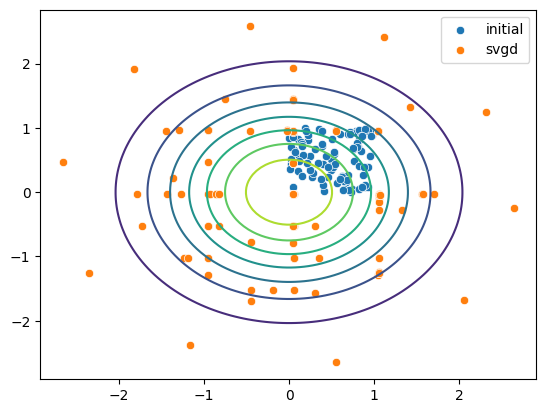

In [110]:
plt.contour(X1_plot, X2_plot, y_plot)
sns.scatterplot(x=k_srf_pre.w[:, 0], y=k_srf_pre.w[:, 1], label="initial")
sns.scatterplot(x=k_srf.w[:, 0], y=k_srf.w[:, 1], label="svgd")

## Run Definition

In [12]:
def run_experiment(key, N, R, d, **kwargs):
    mixture = kwargs.get("mixture", False)

    #### DATA
    X = jax.random.uniform(key, shape=(N, d))
    X_train = jax.random.uniform(jax.random.split(key)[1], shape=(N, d))
    target = tfd.MultivariateNormalDiag(loc=jnp.zeros(d), scale_diag=jnp.ones(d))
    model_subkeys = jax.random.split(key, 6)

    #### KERNELS
    K = ExpSquared()(X, X)
    K_base = jnp.linalg.norm(K)
    
    k_mc = make_mc_rff(model_subkeys[0], R, d)
    K_mc = kernel_proj(k_mc, X)
    err_mc = np.float32(K_norm(K, K_mc) / K_base)

    k_qmc = make_qmc_rff(model_subkeys[1], R, d)
    K_qmc = kernel_proj(k_qmc, X)
    err_qmc = np.float32(K_norm(K, K_qmc) / K_base)

    k_orf = make_orf_rff(model_subkeys[2], R, d)
    K_orf = kernel_proj(k_orf, X)
    err_orf = np.float32(K_norm(K, K_orf) / K_base)

    K_sk, K_nys = nystrom_rbf(model_subkeys[3], X_train, X, R=R)
    err_nys = np.float32(K_norm(K_sk, K_nys) / jnp.linalg.norm(K_sk))

    lr = kwargs.get("lr", 1e-2)
    epochs = kwargs.get("epochs", 20000)
    k_srf_pre = make_srf_rff(model_subkeys[4], R, d)
    k_srf, srf_losses = train_srf_rff(k_srf_pre, target, lr, epochs)
    K_srf = kernel_proj(k_srf, X)
    err_srf = np.float32(K_norm(K, K_srf) / K_base)

    #### Log
    res = {
        "seed": int(key[0]),
        "N": N,
        "R": R,
        "d": d,
        "lr": lr,
        "epochs": epochs,
        "mc": err_mc,
        "qmc": err_qmc,
        "orf": err_orf,
        "nys": err_nys,
        "srf": err_srf,
    }

    return res


In [13]:
def multi_run(key, N, R, d, n_runs, **kwargs):
    res = []
    for i in range(n_runs):
        epochs = kwargs.get("epochs", 15000)
        lr = kwargs.get("lr", 3e-1)
        # print(f"N: {N}, R: {R}, d: {d}, epochs: {epochs}, lr: {lr}, run: {i+1}/{n_runs}")
        key, subkey = jax.random.split(key)
        new_exp = run_experiment(subkey, N, R, d, epochs=epochs, lr=lr)
        print(new_exp)
        res.append(new_exp)
    
    return res

In [14]:
def results_df(res_li):
    res = pd.DataFrame(res_li)
    res = res.melt(id_vars=["seed", "N", "R", "d", "lr", "epochs"], var_name="method", value_name="error")
    res["error"] = res["error"].astype(np.float64)
    return res

### Runs Over Epochs

In [ ]:
# epoch_opts = [100, 500, 1000, 2500, 5000, 10000, 15000, 20000]
epoch_opts = [10000, 15000]
epoch_res = []
for epc in epoch_opts:
    print(f"epochs: {epc}")
    epc_res = multi_run(key, N=1000, R=100, d=2, n_runs=5, lr=3e-1, epochs=epc)
    epoch_res.extend(epc_res)

epoch_res_df = results_df(epoch_res)
epoch_res_df.to_csv("kernel/epoch.csv", index=False)

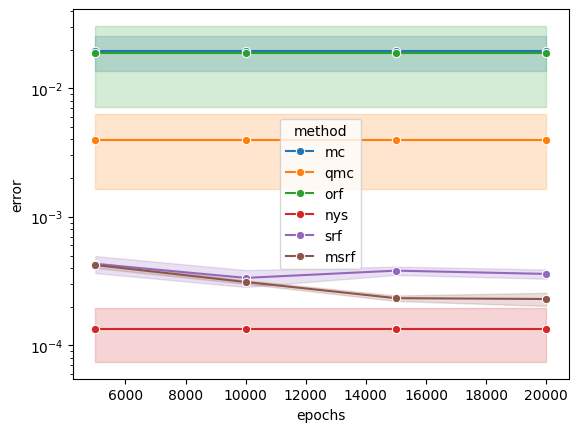

In [85]:
# 10k min error around 0.0004, while nystrom 0.0001
sns.lineplot(data=epoch_res_df, x="epochs", y="error", hue="method", errorbar="sd", marker="o")
plt.yscale("log")

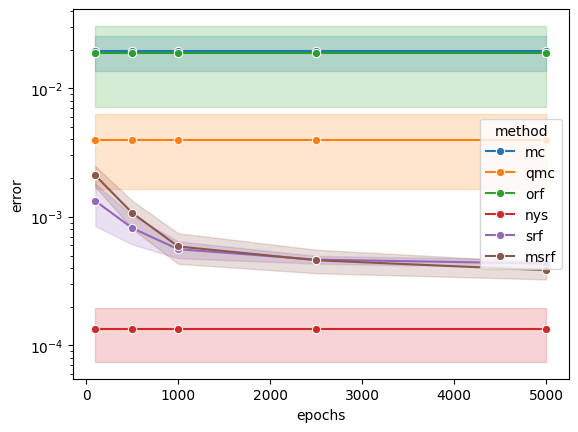

In [89]:
# epoch_plot = epoch_res_df.drop(epoch_res_df[epoch_res_df["method"] == "mixsrf"].index).reset_index(drop=True)
sns.lineplot(data=epoch_res_df, x="epochs", y="error", hue="method", errorbar="sd", marker="o")
plt.yscale("log")


### Run Over R

In [15]:
Rs = [10, 50, 100, 200, 300, 500, 750, 1000]
Rs_res = []
for _R in Rs:
    print(f"R: {_R}")
    R_res = multi_run(key, N=1000, R=_R, d=2, n_runs=5, lr=3e-1, epochs=15000)
    Rs_res.extend(R_res)

Rs_df = results_df(Rs_res)
Rs_df.to_csv("kernel/R.csv", index=False)

R: 10
{'seed': 2718843009, 'N': 1000, 'R': 10, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.059066758, 'qmc': 0.026979927, 'orf': 0.06863743, 'nys': 7.7745746e-05, 'srf': 0.005520067, 'msrf': 0.005588802}
{'seed': 1278412471, 'N': 1000, 'R': 10, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.035384957, 'qmc': 0.035235517, 'orf': 0.1846962, 'nys': 0.0010529095, 'srf': 0.0055543296, 'msrf': 0.0055919914}
{'seed': 4104543539, 'N': 1000, 'R': 10, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.016797572, 'qmc': 0.026759623, 'orf': 0.08539503, 'nys': 0.00035773253, 'srf': 0.005507573, 'msrf': 0.005550945}
{'seed': 1194623263, 'N': 1000, 'R': 10, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.08508279, 'qmc': 0.022152465, 'orf': 0.09414624, 'nys': 0.000111832815, 'srf': 0.016802186, 'msrf': 0.0056221103}
{'seed': 2205739499, 'N': 1000, 'R': 10, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.08213662, 'qmc': 0.021389607, 'orf': 0.037071902, 'nys': 0.0007698992, 'srf': 0.005549284, 'msrf': 0.005582764}
R: 5

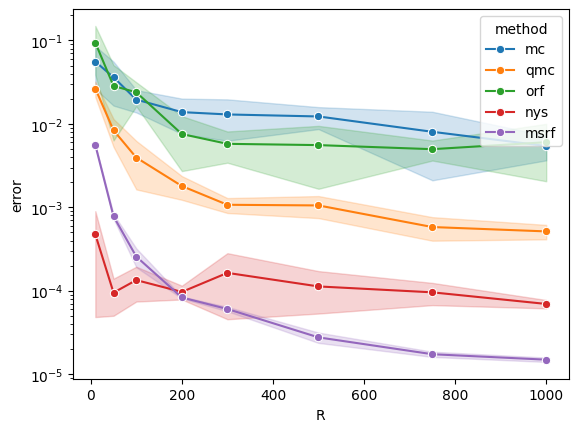

In [16]:
Rs_plot = Rs_df.drop(Rs_df[Rs_df["method"] == "srf"].index).reset_index(drop=True)
sns.lineplot(data=Rs_plot, x="R", y="error", hue="method", errorbar="sd", marker="o")
plt.yscale("log")

### Run Over D

In [22]:
Ds = range(2, 32, 2)
Ds_res = []
for _d in Ds:
    print(f"d: {_d}")
    D_res = multi_run(key, N=1000, R=200, d=_d, n_runs=5, lr=3e-1, epochs=15000)
    Ds_res.extend(D_res)

Ds_df = results_df(Ds_res)
Ds_df.to_csv("kernel/D.csv", index=False)

d: 2
{'seed': 2718843009, 'N': 1000, 'R': 200, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.01710756, 'qmc': 0.0015385889, 'orf': 0.0072183376, 'nys': 0.00012104787, 'srf': 9.45888e-05, 'msrf': 8.554534e-05}
{'seed': 1278412471, 'N': 1000, 'R': 200, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.0042351573, 'qmc': 0.0015641705, 'orf': 0.005819719, 'nys': 8.153109e-05, 'srf': 0.00012209448, 'msrf': 8.063529e-05}
{'seed': 4104543539, 'N': 1000, 'R': 200, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.010856754, 'qmc': 0.0026042275, 'orf': 0.009783126, 'nys': 0.00011201456, 'srf': 8.848248e-05, 'msrf': 8.118365e-05}
{'seed': 1194623263, 'N': 1000, 'R': 200, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.019302787, 'qmc': 0.0011575187, 'orf': 0.008954892, 'nys': 8.36237e-05, 'srf': 7.274697e-05, 'msrf': 8.494718e-05}
{'seed': 2205739499, 'N': 1000, 'R': 200, 'd': 2, 'lr': 0.3, 'epochs': 15000, 'mc': 0.017672857, 'qmc': 0.0021349506, 'orf': 0.014436093, 'nys': 8.66535e-05, 'srf': 0.000110148554, 'msr

<Axes: xlabel='d', ylabel='error'>

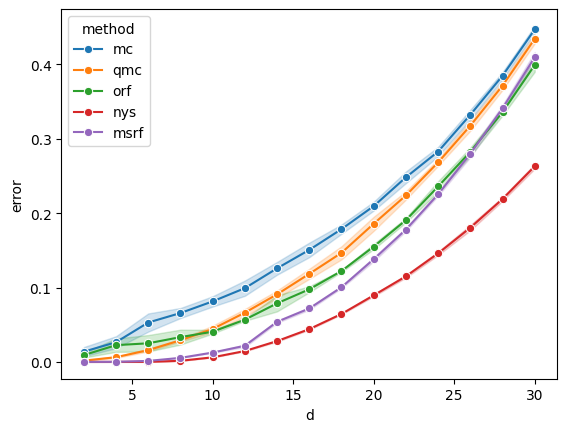

In [25]:
Ds_plot = Ds_df.drop(Ds_df[Ds_df["method"] == "srf"].index).reset_index(drop=True)
sns.lineplot(data=Ds_plot, x="d", y="error", hue="method", errorbar="sd", marker="o")
# plt.yscale("log")